# Open Cluster Analysis using data from Gaia - Membership Analysis

In [12]:
# Membershipo analysis in Open Clusters
# This notebooks shows different methods to determine which stars
# belong to an open cluster using from the ESA's mission Gaia

import numpy as np
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
import hdbscan
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)


BLOCK 1: DOWNLOADING DATA FROM GAIA

Analyzing cluster: NGC 2516
Coordinates: RA=119.5°, Dec=-60.75°
Search radius: 0.5°

  Intentando autenticación en Gaia...
INFO: Login to gaia TAP server [astroquery.gaia.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Login to gaia data server [astroquery.gaia.core]
INFO: OK [astroquery.utils.tap.core]
  ✓ Login exitoso en Gaia (queries ilimitadas)
\Downloading data from Gaia DR3...

 Running asynchronous query (may take 1-2 minutes)...
INFO: Query finished. [astroquery.utils.tap.core]
  Download complete (async): 6285 stars

Data downloaded sucessfully!
Total number of stars: 6285


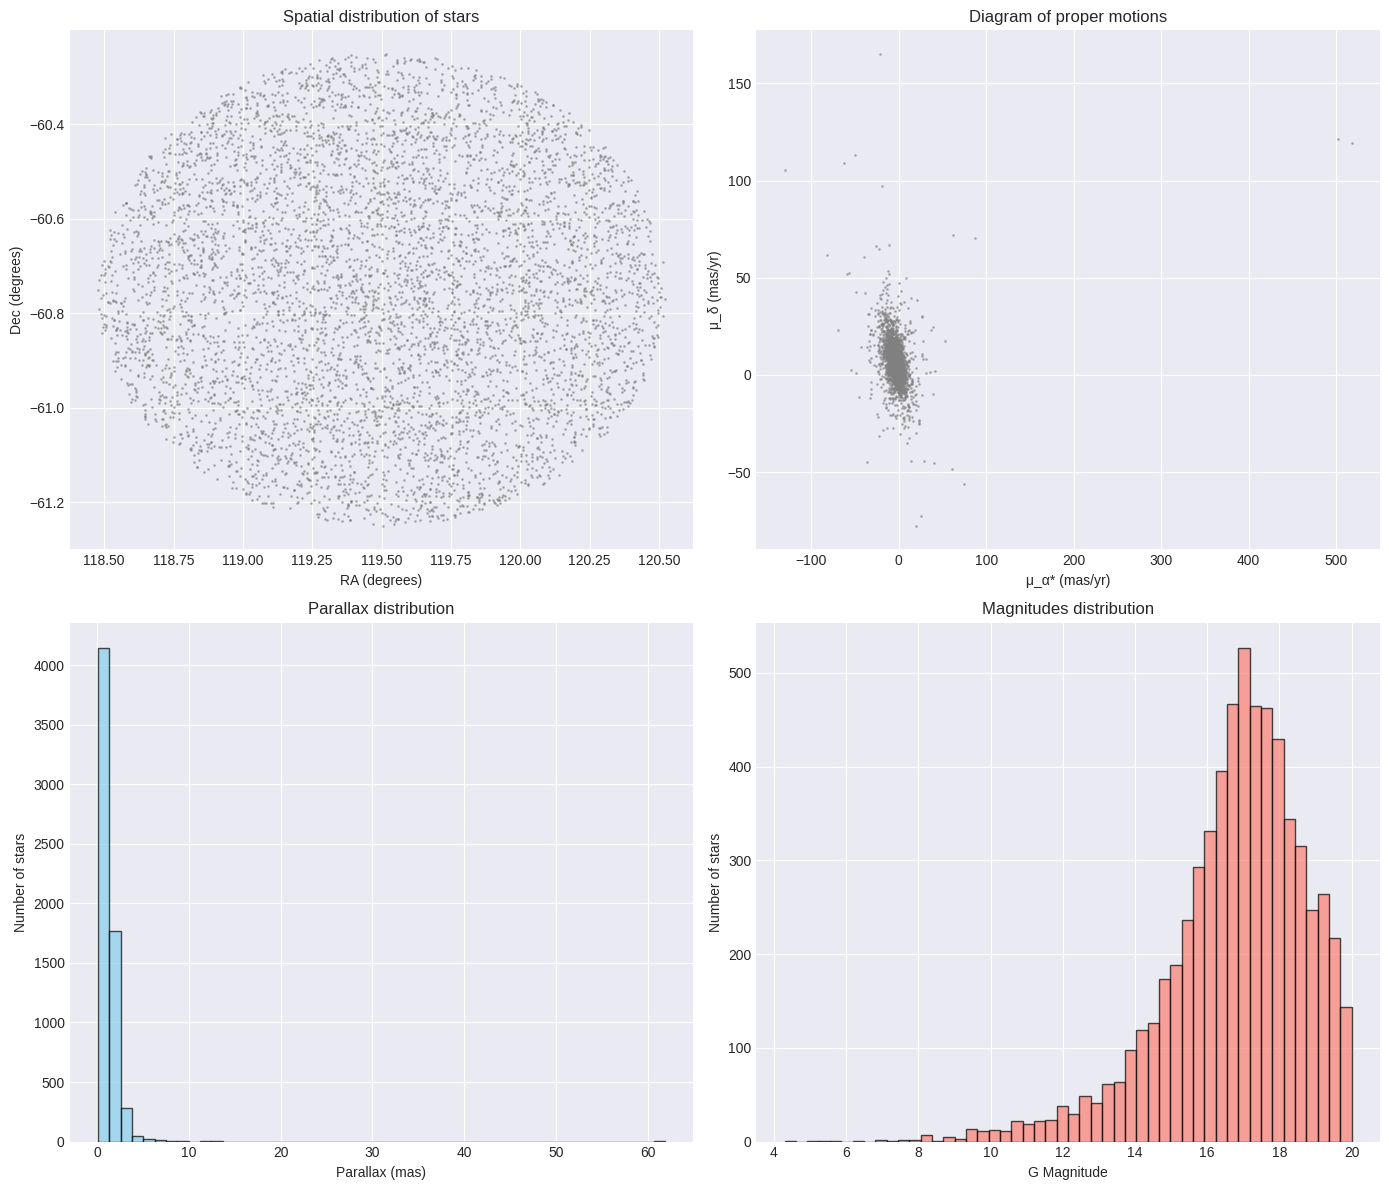


Basic data statistics:
  Mean parallax: 1.25 ± 1.46 mas
  Mean μ_α* : -3.73 ± 11.31 mas/yr
  Mean μ_δ: 7.69 ± 8.84 mas/yr


In [ ]:
# =============================================================================
# BLOCK 1: DOWNLOADING DATA FROM GAIA
# =============================================================================

print("="*70)
print("BLOCK 1: DOWNLOADING DATA FROM GAIA")
print("="*70)

# Parameters of the cluster to be analysed
cluster_name = "NGC 2516"  # You can change this to any other cluster.
cluster_ra = 119.5  # Right Ascension in degrees
cluster_dec = -60.75  # Declination in degrees
search_radius = 0.5  # Search radius in degrees

print(f"\nAnalyzing cluster: {cluster_name}")
print(f"Coordinates: RA={cluster_ra}°, Dec={cluster_dec}°")
print(f"Search radius: {search_radius}°")

# Construction of the ADQL (Astronomical Data Query Language) query
# This query selects stars with good astrometric data.
query = f"""
SELECT 
    ra, dec, pmra, pmdec, parallax,
    phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag,
    ruwe, astrometric_excess_noise
FROM gaiadr3.gaia_source
WHERE 1=CONTAINS(
    POINT('ICRS', ra, dec),
    CIRCLE('ICRS', {cluster_ra}, {cluster_dec}, {search_radius})
)
AND parallax IS NOT NULL
AND parallax/parallax_error > 5
AND pmra IS NOT NULL
AND pmdec IS NOT NULL
AND ruwe < 1.4
AND phot_g_mean_mag < 20
ORDER BY phot_g_mean_mag
"""
gaia_username="user"
gaia_password="pass"
authenticated = False

if gaia_username and gaia_password:
    try:
        print(f"\n  Intentando autenticación en Gaia...")
        Gaia.login(user=gaia_username, password=gaia_password)
        authenticated = True
        print("  ✓ Login exitoso en Gaia (queries ilimitadas)")
    except Exception as e:
        print(f"  ⚠ Login falló: {e}")
        print("  → Continuando sin autenticación (límite ~2000 filas)")


print("\Downloading data from Gaia DR3...")

try:
    if authenticated:
        # Asynchronous query
        print(f"\n Running asynchronous query (may take 1-2 minutes)...")
        job = Gaia.launch_job_async(query)
        data = job.get_results()
        print(f"  Download complete (async): {len(data)} stars")
    else:
        # Asynchronous query (anonymous, limited to 2000 rows)
        print(f"\n Running synchronous query...")
        job = Gaia.launch_job(query)
        data = job.get_results()
        print(f"  Download complete (sync): {len(data)} stars")
    
except Exception as e:
    print(f"\n Error executing query in Gaia: {e}")
    print("\nPossible causes:")
    print("  - Query too large (>2000 rows without authentication)")
    print("  - Server timeout")
    print("  - Incorrect ADQL syntax")
    raise
    
print(f"\nData downloaded sucessfully!")
print(f"Total number of stars: {len(data)}")

# Convert to numpy arrays for easier analysis
ra = np.array(data['ra'])
dec = np.array(data['dec'])
pmra = np.array(data['pmra'])
pmdec = np.array(data['pmdec'])
parallax = np.array(data['parallax'])
gmag = np.array(data['phot_g_mean_mag'])

# Initial data visualisation
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

axes[0, 0].scatter(ra, dec, s=1, alpha=0.5, c='gray')
axes[0, 0].set_xlabel('RA (degrees)')
axes[0, 0].set_ylabel('Dec (degrees)')
axes[0, 0].set_title('Spatial distribution of stars')

axes[0, 1].scatter(pmra, pmdec, s=1, alpha=0.5, c='gray')
axes[0, 1].set_xlabel('μ_α* (mas/yr)')
axes[0, 1].set_ylabel('μ_δ (mas/yr)')
axes[0, 1].set_title('Diagram of proper motions')

axes[1, 0].hist(parallax, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[1, 0].set_xlabel('Parallax (mas)')
axes[1, 0].set_ylabel('Number of stars')
axes[1, 0].set_title('Parallax distribution')

axes[1, 1].hist(gmag, bins=50, alpha=0.7, color='salmon', edgecolor='black')
axes[1, 1].set_xlabel('G Magnitude')
axes[1, 1].set_ylabel('Number of stars')
axes[1, 1].set_title('Magnitudes distribution')

plt.tight_layout()
plt.savefig('initial_data.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nBasic data statistics:")
print(f"  Mean parallax: {np.mean(parallax):.2f} ± {np.std(parallax):.2f} mas")
print(f"  Mean μ_α* : {np.mean(pmra):.2f} ± {np.std(pmra):.2f} mas/yr")
print(f"  Mean μ_δ: {np.mean(pmdec):.2f} ± {np.std(pmdec):.2f} mas/yr")


BLOCK 2: MEMBERSHIP ANALYSIS WITH DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is an 
algorithm that clusters points based on their local density. 

The algorithm has two main parameters:
- eps (epsilon): the maximum distance between two points for them to be considered neighbours.
- min_samples: the minimum number of points needed to form a dense cluster.

DBSCAN is particularly effective for clusters because:
1. It does not assume that clusters are spherical in shape.
2. It can identify points as ‘noise’ (outliers).
3. It does not need to know in advance how many clusters there are.


Aplying DBSCAN...
Parameters: eps=0.3, min_samples=10

DBSCAN results:
  Number of clusters identified: 2
  Stars classified as noise (field): 542
  Stars in clusters: 5743
  Main cluster has 5729 stars


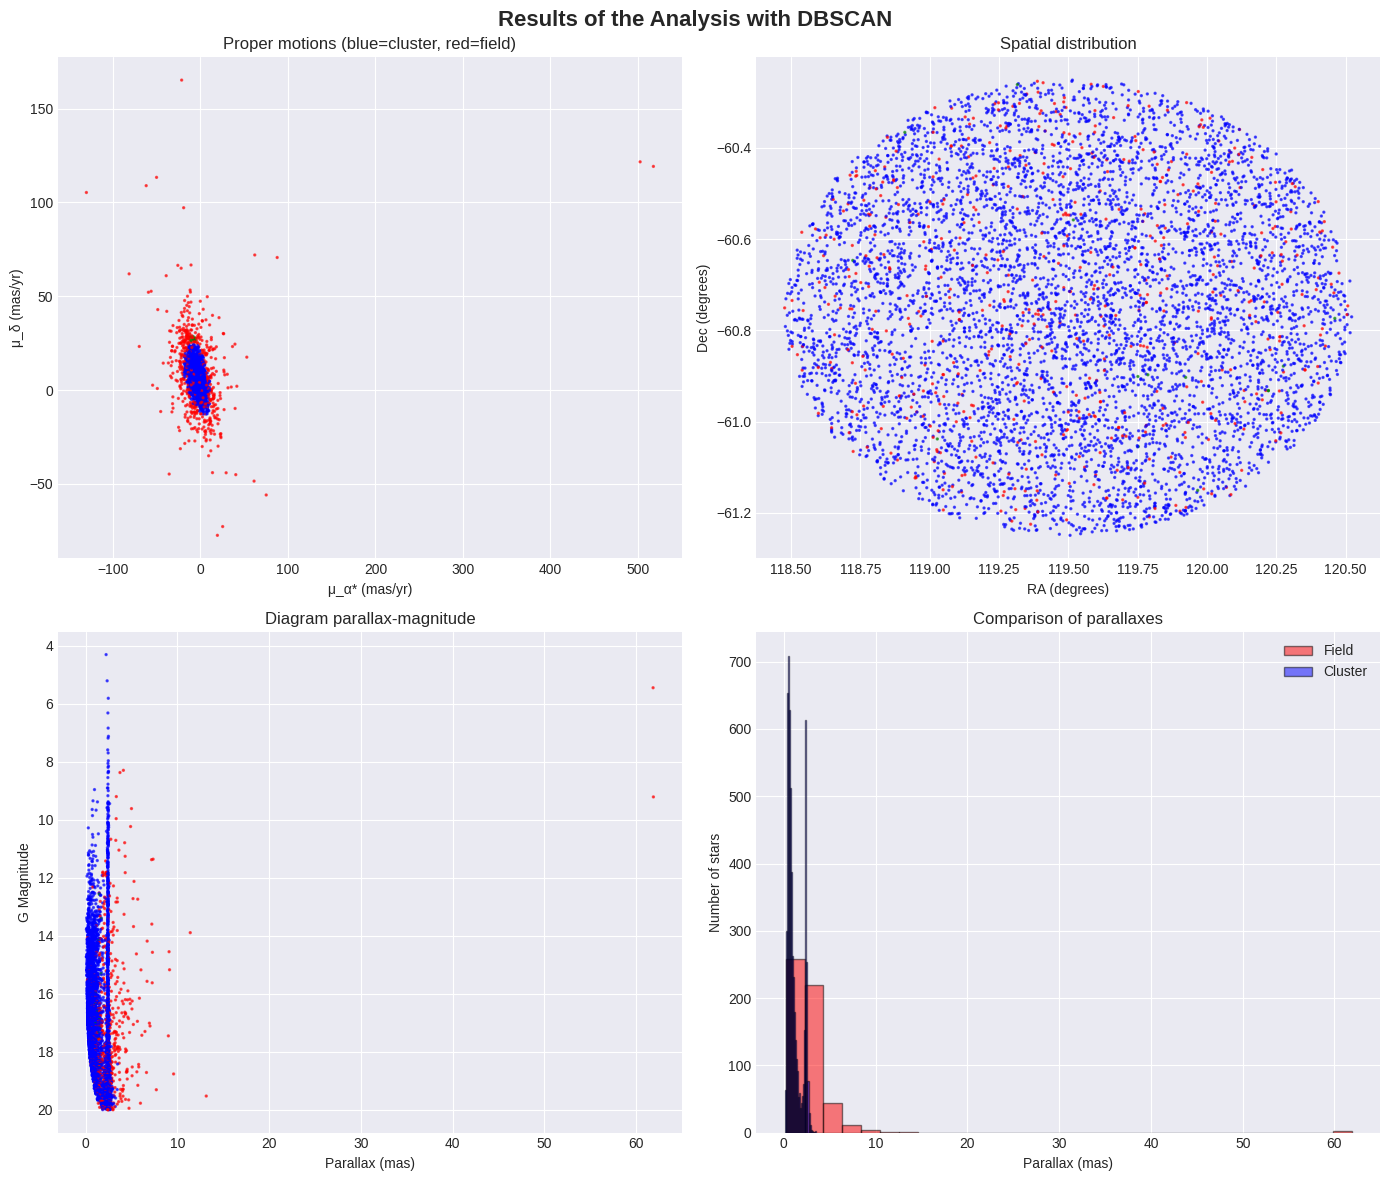

In [14]:
# =============================================================================
# BLOCK 2: MEMBERSHIP ANALYSIS WITH DBSCAN
# =============================================================================

print("\n" + "="*70)
print("BLOCK 2: MEMBERSHIP ANALYSIS WITH DBSCAN")
print("="*70)

print("""
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is an 
algorithm that clusters points based on their local density. 

The algorithm has two main parameters:
- eps (epsilon): the maximum distance between two points for them to be considered neighbours.
- min_samples: the minimum number of points needed to form a dense cluster.

DBSCAN is particularly effective for clusters because:
1. It does not assume that clusters are spherical in shape.
2. It can identify points as ‘noise’ (outliers).
3. It does not need to know in advance how many clusters there are.
""")

# Prepare the data for clustering
# We will use proper motion and parallax (the most discriminating space).
X_dbscan = np.column_stack([pmra, pmdec, parallax])

# Normalise the data so that all dimensions have similar weight
# This is crucial because pmra, pmdec, and parallax have different scales.
scaler_dbscan = StandardScaler()
X_dbscan_scaled = scaler_dbscan.fit_transform(X_dbscan)

print("\nAplying DBSCAN...")
print("Parameters: eps=0.3, min_samples=10")

# Apply DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=10)
labels_dbscan = dbscan.fit_predict(X_dbscan_scaled)

# Analysis of results
n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise_dbscan = list(labels_dbscan).count(-1)

print(f"\nDBSCAN results:")
print(f"  Number of clusters identified: {n_clusters_dbscan}")
print(f"  Stars classified as noise (field): {n_noise_dbscan}")
print(f"  Stars in clusters: {len(data) - n_noise_dbscan}")

# We assume that the main cluster is the largest group (excluding noise).
if n_clusters_dbscan > 0:
    cluster_sizes = [np.sum(labels_dbscan == i) for i in range(n_clusters_dbscan)]
    main_cluster_id = np.argmax(cluster_sizes)
    mask_members_dbscan = labels_dbscan == main_cluster_id
    print(f"  Main cluster has {cluster_sizes[main_cluster_id]} stars")
else:
    mask_members_dbscan = np.zeros(len(data), dtype=bool)

# Visualisation
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Results of the Analysis with DBSCAN', fontsize=16, fontweight='bold')

# Diagram of proper motions
colors_dbscan = ['red' if x == -1 else 'blue' if x == main_cluster_id else 'green' 
                 for x in labels_dbscan]
axes[0, 0].scatter(pmra, pmdec, c=colors_dbscan, s=2, alpha=0.6)
axes[0, 0].set_xlabel('μ_α* (mas/yr)')
axes[0, 0].set_ylabel('μ_δ (mas/yr)')
axes[0, 0].set_title('Proper motions (blue=cluster, red=field)')

# Spatial distribution
axes[0, 1].scatter(ra, dec, c=colors_dbscan, s=2, alpha=0.6)
axes[0, 1].set_xlabel('RA (degrees)')
axes[0, 1].set_ylabel('Dec (degrees)')
axes[0, 1].set_title('Spatial distribution')

# Parallax vs magnitude
axes[1, 0].scatter(parallax, gmag, c=colors_dbscan, s=2, alpha=0.6)
axes[1, 0].set_xlabel('Parallax (mas)')
axes[1, 0].set_ylabel('G Magnitude')
axes[1, 0].invert_yaxis()
axes[1, 0].set_title('Diagram parallax-magnitude')

# Histogram of parallaxes
axes[1, 1].hist(parallax[labels_dbscan == -1], bins=30, alpha=0.5, 
                label='Field', color='red', edgecolor='black')
if np.sum(mask_members_dbscan) > 0:
    axes[1, 1].hist(parallax[mask_members_dbscan], bins=30, alpha=0.5, 
                    label='Cluster', color='blue', edgecolor='black')
axes[1, 1].set_xlabel('Parallax (mas)')
axes[1, 1].set_ylabel('Number of stars')
axes[1, 1].set_title('Comparison of parallaxes')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('results_dbscan.png', dpi=150, bbox_inches='tight')
plt.show()


BLOCK 3: MEMBERSHIP ANALYSIS WITH HDBSCAN

HDBSCAN (Hierarchical DBSCAN) is an evolution of DBSCAN that solves one of its
main problems: DBSCAN assumes that density is uniform throughout space,
but in astrophysics this is rarely true. A cluster can have a very dense core
and a more dispersed corona.

HDBSCAN uses one main parameter:
- min_cluster_size: the minimum size of a group to be considered a valid cluster.

Advantages of HDBSCAN for open clusters:
1. It handles density variations within the cluster.
2. It is more robust in terms of parameter choice.
3. It provides a measure of ‘membership probability’ for each star.
4. It better detects hierarchical structures (such as sub-clusters).

\Applying HDBSCAN...
Parameters: min_cluster_size=15, min_samples=5

HDBSCAN results:
  Number of clusters identified: 3
  Stars classified as noise (field): 588
  Stars in clusters: 5697
  Main cluster has 4410 stars
  Mean membership probability: 0.813


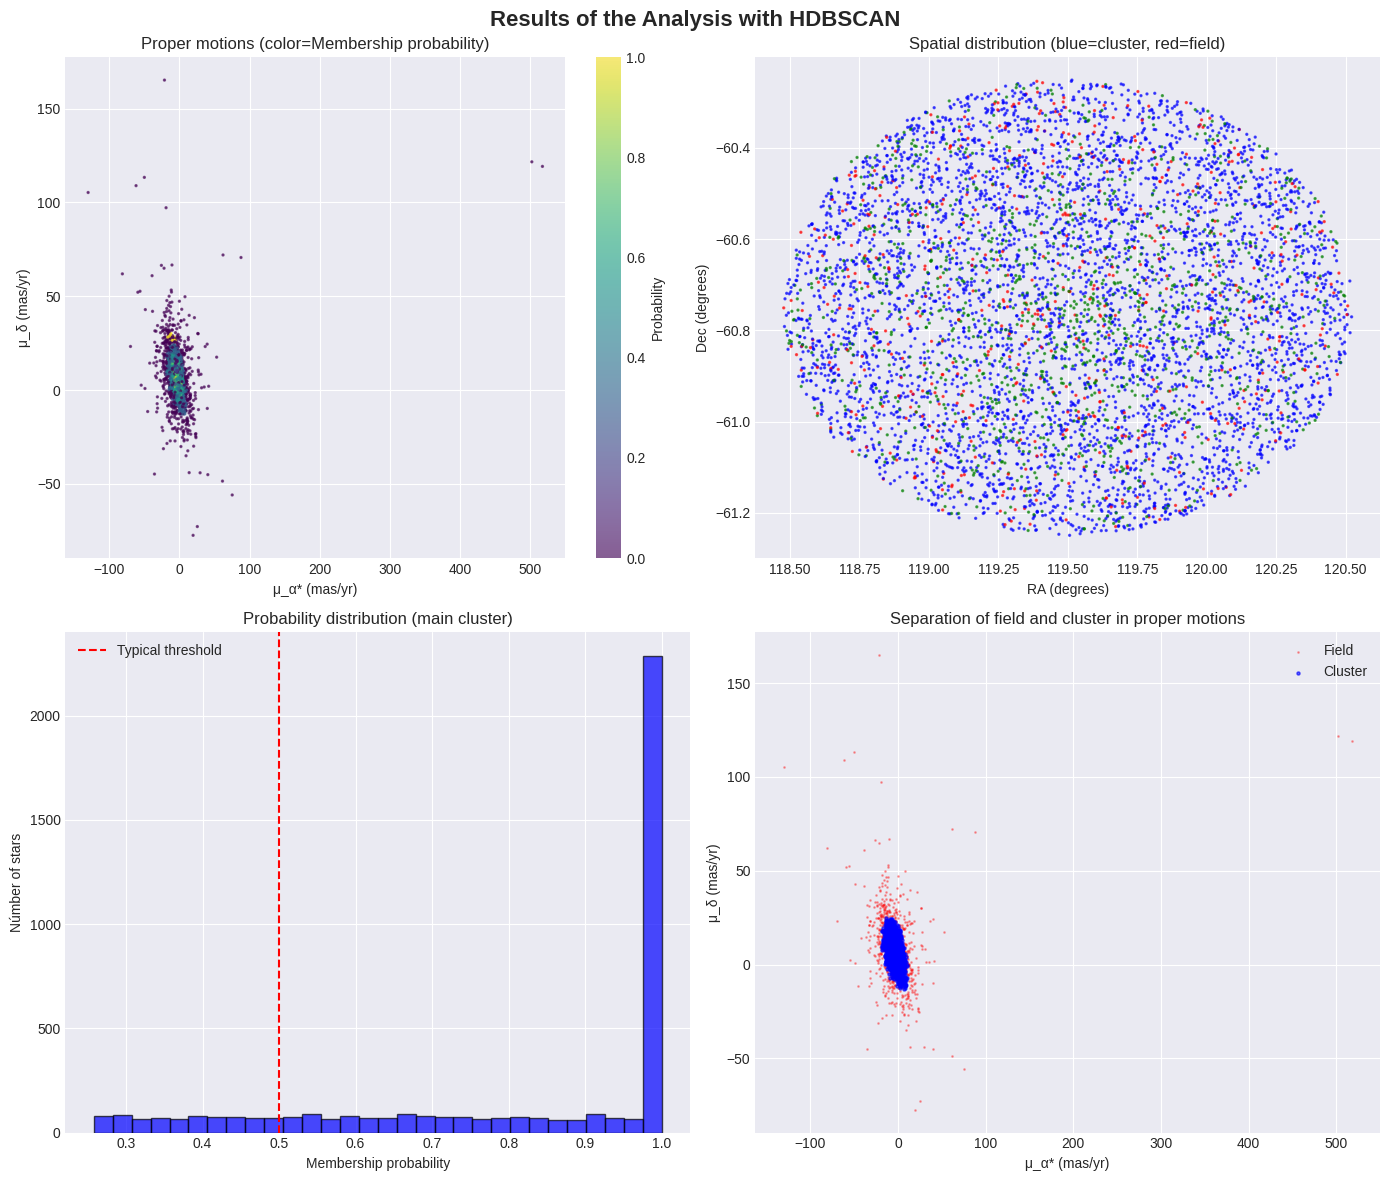

In [15]:
# =============================================================================
# BLOCK 3: MEMBERSHIP ANALYSIS WITH HDBSCAN
# =============================================================================

print("\n" + "="*70)
print("BLOCK 3: MEMBERSHIP ANALYSIS WITH HDBSCAN")
print("="*70)

print("""
HDBSCAN (Hierarchical DBSCAN) is an evolution of DBSCAN that solves one of its
main problems: DBSCAN assumes that density is uniform throughout space,
but in astrophysics this is rarely true. A cluster can have a very dense core
and a more dispersed corona.

HDBSCAN uses one main parameter:
- min_cluster_size: the minimum size of a group to be considered a valid cluster.

Advantages of HDBSCAN for open clusters:
1. It handles density variations within the cluster.
2. It is more robust in terms of parameter choice.
3. It provides a measure of ‘membership probability’ for each star.
4. It better detects hierarchical structures (such as sub-clusters).
""")

# Use the same standardised data
X_hdbscan_scaled = X_dbscan_scaled.copy()

print("\Applying HDBSCAN...")
print("Parameters: min_cluster_size=15, min_samples=5")

# Apply HDBSCAN
hdb = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=5)
labels_hdbscan = hdb.fit_predict(X_hdbscan_scaled)

# HDBSCAN provides membership probabilities
probabilities_hdbscan = hdb.probabilities_

# Analysis of results
n_clusters_hdbscan = len(set(labels_hdbscan)) - (1 if -1 in labels_hdbscan else 0)
n_noise_hdbscan = list(labels_hdbscan).count(-1)

print(f"\nHDBSCAN results:")
print(f"  Number of clusters identified: {n_clusters_hdbscan}")
print(f"  Stars classified as noise (field): {n_noise_hdbscan}")
print(f"  Stars in clusters: {len(data) - n_noise_hdbscan}")

# Identify the main cluster
if n_clusters_hdbscan > 0:
    cluster_sizes_hdb = [np.sum(labels_hdbscan == i) for i in range(n_clusters_hdbscan)]
    main_cluster_id_hdb = np.argmax(cluster_sizes_hdb)
    mask_members_hdbscan = labels_hdbscan == main_cluster_id_hdb
    print(f"  Main cluster has {cluster_sizes_hdb[main_cluster_id_hdb]} stars")
    print(f"  Mean membership probability: {np.mean(probabilities_hdbscan[mask_members_hdbscan]):.3f}")
else:
    mask_members_hdbscan = np.zeros(len(data), dtype=bool)

# Visualisation
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Results of the Analysis with HDBSCAN', fontsize=16, fontweight='bold')

# Diagram of proper motions with probabilities
scatter = axes[0, 0].scatter(pmra, pmdec, c=probabilities_hdbscan, 
                             s=2, alpha=0.6, cmap='viridis')
axes[0, 0].set_xlabel('μ_α* (mas/yr)')
axes[0, 0].set_ylabel('μ_δ (mas/yr)')
axes[0, 0].set_title('Proper motions (color=Membership probability)')
plt.colorbar(scatter, ax=axes[0, 0], label='Probability')

# Spatial distribution
colors_hdbscan = ['red' if x == -1 else 'blue' if x == main_cluster_id_hdb else 'green' 
                  for x in labels_hdbscan]
axes[0, 1].scatter(ra, dec, c=colors_hdbscan, s=2, alpha=0.6)
axes[0, 1].set_xlabel('RA (degrees)')
axes[0, 1].set_ylabel('Dec (degrees)')
axes[0, 1].set_title('Spatial distribution (blue=cluster, red=field)')

# Probability histogram
axes[1, 0].hist(probabilities_hdbscan[mask_members_hdbscan], bins=30, 
                alpha=0.7, color='blue', edgecolor='black')
axes[1, 0].set_xlabel('Membership probability')
axes[1, 0].set_ylabel('Númber of stars')
axes[1, 0].set_title('Probability distribution (main cluster)')
axes[1, 0].axvline(0.5, color='red', linestyle='--', label='Typical threshold')
axes[1, 0].legend()

# Comparison of densities in proper motion space
axes[1, 1].scatter(pmra[labels_hdbscan == -1], pmdec[labels_hdbscan == -1], 
                   s=1, alpha=0.3, color='red', label='Field')
if np.sum(mask_members_hdbscan) > 0:
    axes[1, 1].scatter(pmra[mask_members_hdbscan], pmdec[mask_members_hdbscan], 
                       s=5, alpha=0.6, color='blue', label='Cluster')
axes[1, 1].set_xlabel('μ_α* (mas/yr)')
axes[1, 1].set_ylabel('μ_δ (mas/yr)')
axes[1, 1].set_title('Separation of field and cluster in proper motions')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('results_hdbscan.png', dpi=150, bbox_inches='tight')
plt.show()



BLOCK 4: ANALYSIS WITH GMM (Gaussian Mixture Models)

GMM (Gaussian Mixture Models) takes a completely different approach. Instead of
searching for dense regions, GMM assumes that the data comes from a mixture of Gaussian
(normal) distributions. It is a probabilistic approach: each star has a certain
probability of belonging to each Gaussian component.

To understand GMM, think about measuring the heights of students in a co-ed school.
If you plot the heights, you will see two overlapping ‘humps’: one for girls (Gaussian 1)
and another for boys (Gaussian 2). GMM attempts to identify these underlying Gaussians.

In the context of open clusters:
- One Gaussian represents the stars in the cluster (centred on the proper motion
  and parallax characteristic of the cluster)
- Other Gaussians may represent the field or sub-populations

Main parameters:
- n_components: number of Gaussians to fit (typically 2: cluster + field)
- covariance_type: how to model the shape of the Gaussians
  * “ful

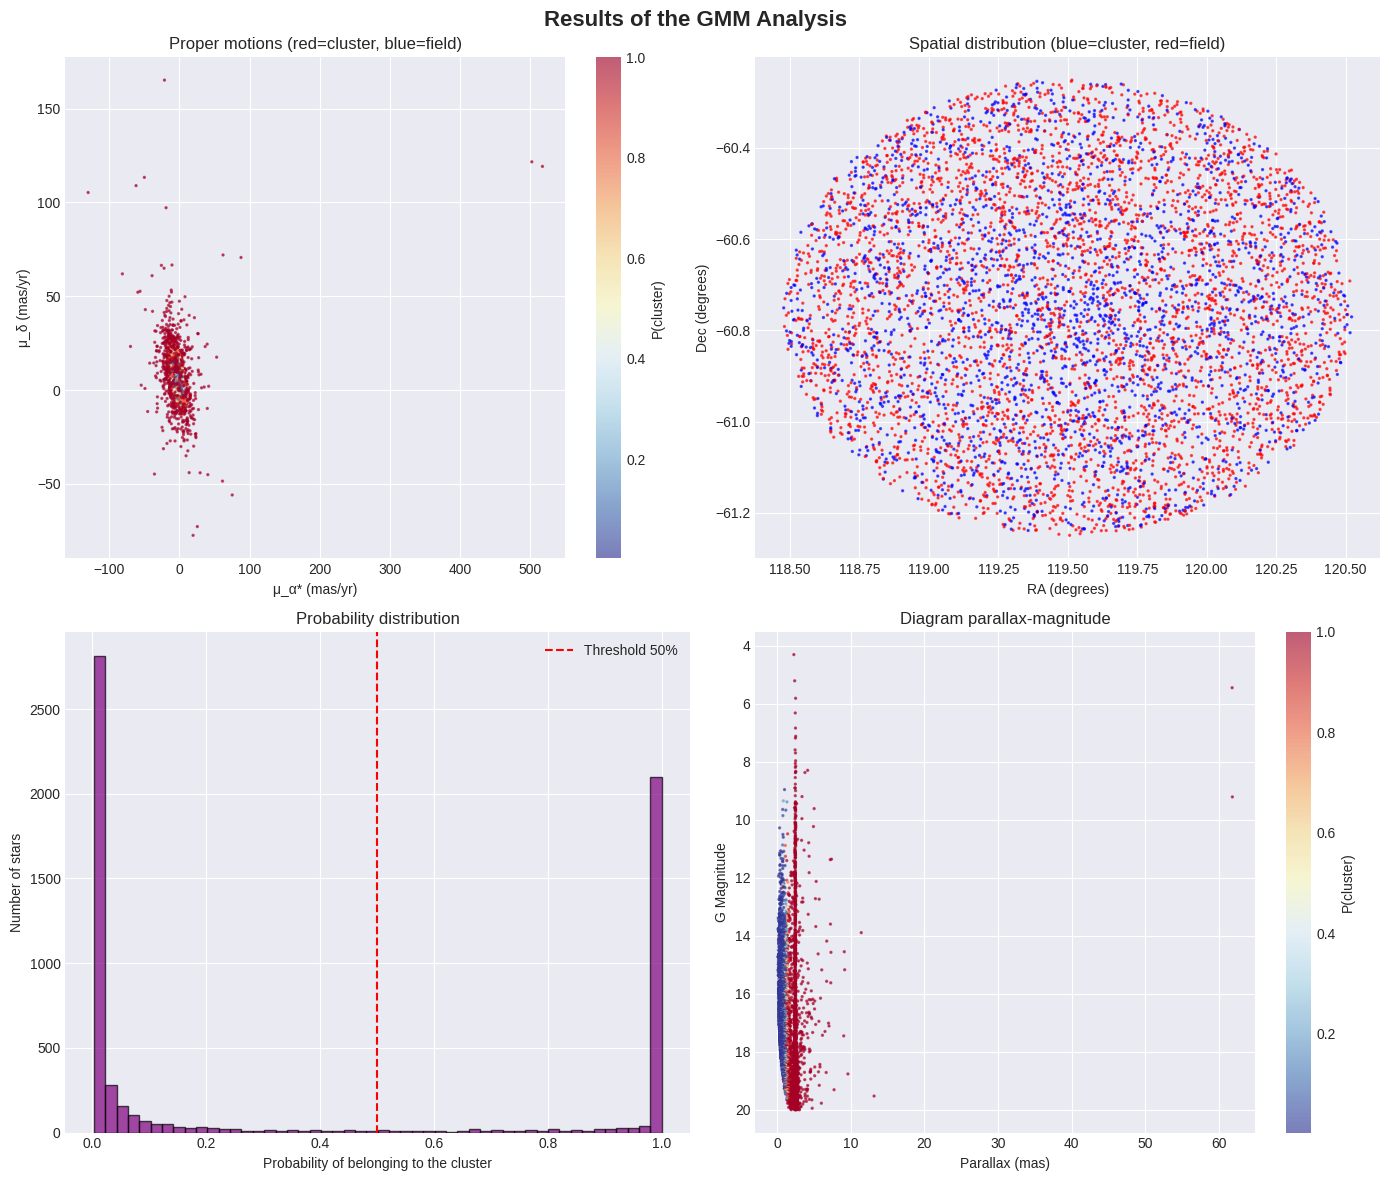

In [16]:
# =============================================================================
# BLOCK 4: MEMBERSHIP ANALYSIS WITH GMM
# =============================================================================

print("\n" + "="*70)
print("BLOCK 4: ANALYSIS WITH GMM (Gaussian Mixture Models)")
print("="*70)

print("""
GMM (Gaussian Mixture Models) takes a completely different approach. Instead of
searching for dense regions, GMM assumes that the data comes from a mixture of Gaussian
(normal) distributions. It is a probabilistic approach: each star has a certain
probability of belonging to each Gaussian component.

To understand GMM, think about measuring the heights of students in a co-ed school.
If you plot the heights, you will see two overlapping ‘humps’: one for girls (Gaussian 1)
and another for boys (Gaussian 2). GMM attempts to identify these underlying Gaussians.

In the context of open clusters:
- One Gaussian represents the stars in the cluster (centred on the proper motion
  and parallax characteristic of the cluster)
- Other Gaussians may represent the field or sub-populations

Main parameters:
- n_components: number of Gaussians to fit (typically 2: cluster + field)
- covariance_type: how to model the shape of the Gaussians
  * “full”: each Gaussian can have any ellipsoidal shape
  * “tied”: all Gaussians have the same shape
  * “diag”: Gaussians with axes aligned to the coordinates
  * “spherical”: circular Gaussians

Advantages of GMM:
1. Provides smooth (non-binary) membership probabilities
2. Has a solid statistical foundation
3. Works well when the cluster and field have different distributions

Disadvantages:
1. Assumes Gaussian distributions (which may not be perfect)
2. Sensitive to initialisation
""")

# Prepare data (we use the same standardised data)
X_gmm_scaled = X_dbscan_scaled.copy()

print("\nApplying GMM with 2 components (cluster + field)...")
print("Parameters: n_components=2, covariance_type='full'")

# Apply GMM
gmm = GaussianMixture(n_components=2, covariance_type='full', 
                      n_init=10, random_state=42)
gmm.fit(X_gmm_scaled)

# Predicting labels and probabilities
labels_gmm = gmm.predict(X_gmm_scaled)
probabilities_gmm = gmm.predict_proba(X_gmm_scaled)

# Identify which component is the cluster
# The cluster typically has larger parallaxes (it is closer) and is more compact.
mean_parallax_comp0 = np.mean(parallax[labels_gmm == 0])
mean_parallax_comp1 = np.mean(parallax[labels_gmm == 1])

# The component with the highest average parallax is probably the cluster.
cluster_component = 0 if mean_parallax_comp0 > mean_parallax_comp1 else 1
mask_members_gmm = labels_gmm == cluster_component

# Probability of belonging to the cluster
prob_cluster_gmm = probabilities_gmm[:, cluster_component]

print(f"\nGMM results:")
print(f"  Component identified as cluster: {cluster_component}")
print(f"  Stars assigned to the cluster: {np.sum(mask_members_gmm)}")
print(f"  Stars assigned to the field: {np.sum(~mask_members_gmm)}")
print(f"  Mean parallax of the cluster: {mean_parallax_comp0 if cluster_component == 0 else mean_parallax_comp1:.2f} mas")
print(f"  Mean parallax of the field: {mean_parallax_comp1 if cluster_component == 0 else mean_parallax_comp0:.2f} mas")

# Probability statistics
print(f"\nStatistics on the probability of belonging to the cluster:")
print(f"  Mean: {np.mean(prob_cluster_gmm[mask_members_gmm]):.3f}")
print(f"  Median: {np.median(prob_cluster_gmm[mask_members_gmm]):.3f}")
print(f"  Minimum: {np.min(prob_cluster_gmm[mask_members_gmm]):.3f}")

# Visualisation
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Results of the GMM Analysis', fontsize=16, fontweight='bold')

# Diagram of own movements with probabilities
scatter = axes[0, 0].scatter(pmra, pmdec, c=prob_cluster_gmm, 
                             s=2, alpha=0.6, cmap='RdYlBu_r')
axes[0, 0].set_xlabel('μ_α* (mas/yr)')
axes[0, 0].set_ylabel('μ_δ (mas/yr)')
axes[0, 0].set_title('Proper motions (red=cluster, blue=field)')
plt.colorbar(scatter, ax=axes[0, 0], label='P(cluster)')

# Spatial distribution
colors_gmm = ['blue' if m else 'red' for m in mask_members_gmm]
axes[0, 1].scatter(ra, dec, c=colors_gmm, s=2, alpha=0.6)
axes[0, 1].set_xlabel('RA (degrees)')
axes[0, 1].set_ylabel('Dec (degrees)')
axes[0, 1].set_title('Spatial distribution (blue=cluster, red=field)')

# Probabilities Histogram
axes[1, 0].hist(prob_cluster_gmm, bins=50, alpha=0.7, 
                color='purple', edgecolor='black')
axes[1, 0].set_xlabel('Probability of belonging to the cluster')
axes[1, 0].set_ylabel('Number of stars')
axes[1, 0].set_title('Probability distribution')
axes[1, 0].axvline(0.5, color='red', linestyle='--', label='Threshold 50%')
axes[1, 0].legend()

# Parallax-magnitude diagram with colours by probability
scatter2 = axes[1, 1].scatter(parallax, gmag, c=prob_cluster_gmm, 
                              s=2, alpha=0.6, cmap='RdYlBu_r')
axes[1, 1].set_xlabel('Parallax (mas)')
axes[1, 1].set_ylabel('G Magnitude')
axes[1, 1].invert_yaxis()
axes[1, 1].set_title('Diagram parallax-magnitude')
plt.colorbar(scatter2, ax=axes[1, 1], label='P(cluster)')

plt.tight_layout()
plt.savefig('results_gmm.png', dpi=150, bbox_inches='tight')
plt.show()


BLOCK 5: COMPARATIVE ANALYSIS OF RESULTS

Now let's compare the three methods to understand their strengths and weaknesses.
Each method has its own philosophy and produces slightly different results.


Comparison of results:
----------------------------------------------------------------------
Method       N_members    Parallax             μ_α*         μ_δ         
----------------------------------------------------------------------
DBSCAN       5729           1.10±0.78    -3.75      7.44
HDBSCAN      4410           0.72±0.39    -3.52      6.35
GMM          2457           2.23±1.93    -4.40      9.91
----------------------------------------------------------------------

Agreement between methods:
  DBSCAN ∩ HDBSCAN: 4396 stars
  DBSCAN ∩ GMM: 1901 stars
  HDBSCAN ∩ GMM: 584 stars
  Total agreement (all 3 methods): 570 stars


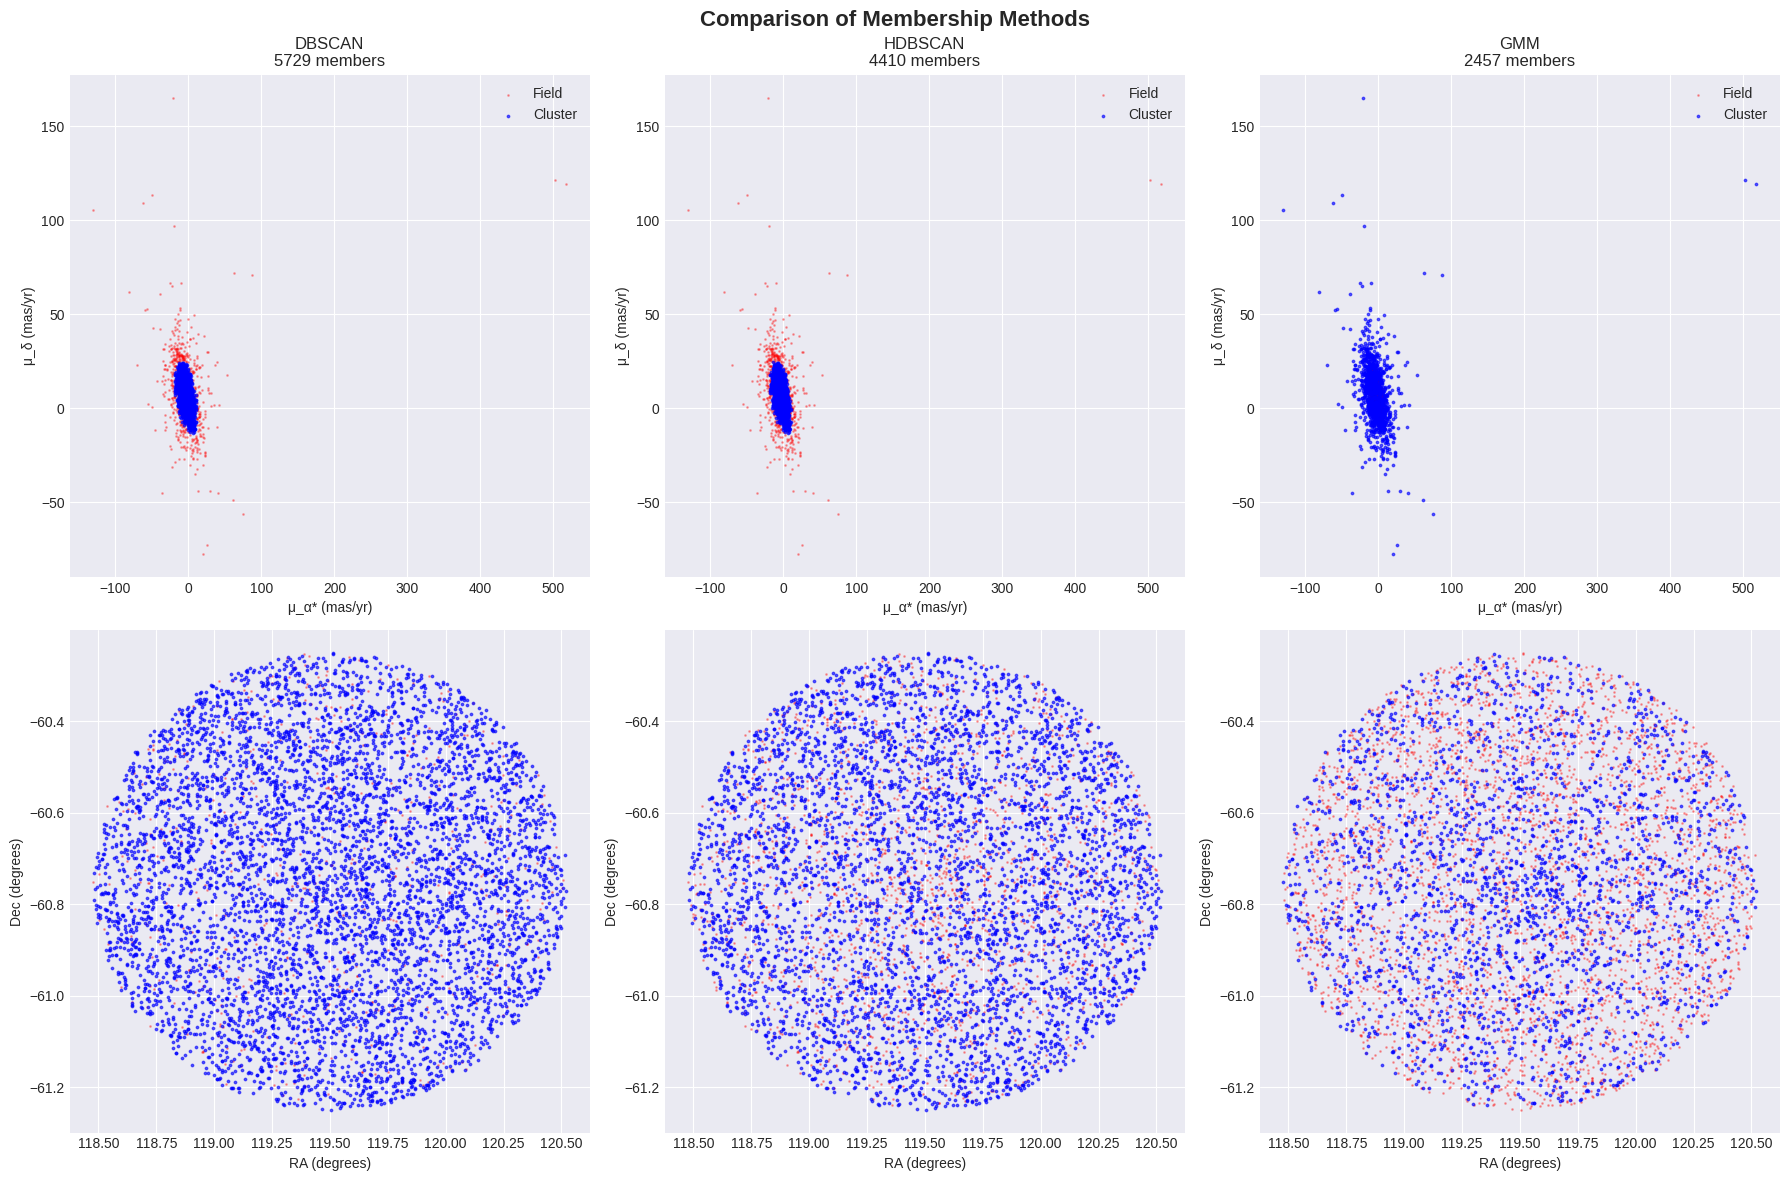


Overlap analysis:
  Only DBSCAN: 2 stars
  Only HDBSCAN: 0 stars
  Only GMM: 542 stars


In [17]:
# =============================================================================
# BLOCK 5: COMPARATIVE ANALYSIS OF RESULTS
# =============================================================================

print("\n" + "="*70)
print("BLOCK 5: COMPARATIVE ANALYSIS OF RESULTS")
print("="*70)

print("""
Now let's compare the three methods to understand their strengths and weaknesses.
Each method has its own philosophy and produces slightly different results.
""")

# Calcular estadísticas comparativas
stats = {
    'DBSCAN': {
        'n_members': np.sum(mask_members_dbscan),
        'mean_parallax': np.mean(parallax[mask_members_dbscan]) if np.sum(mask_members_dbscan) > 0 else 0,
        'std_parallax': np.std(parallax[mask_members_dbscan]) if np.sum(mask_members_dbscan) > 0 else 0,
        'mean_pmra': np.mean(pmra[mask_members_dbscan]) if np.sum(mask_members_dbscan) > 0 else 0,
        'mean_pmdec': np.mean(pmdec[mask_members_dbscan]) if np.sum(mask_members_dbscan) > 0 else 0,
    },
    'HDBSCAN': {
        'n_members': np.sum(mask_members_hdbscan),
        'mean_parallax': np.mean(parallax[mask_members_hdbscan]) if np.sum(mask_members_hdbscan) > 0 else 0,
        'std_parallax': np.std(parallax[mask_members_hdbscan]) if np.sum(mask_members_hdbscan) > 0 else 0,
        'mean_pmra': np.mean(pmra[mask_members_hdbscan]) if np.sum(mask_members_hdbscan) > 0 else 0,
        'mean_pmdec': np.mean(pmdec[mask_members_hdbscan]) if np.sum(mask_members_hdbscan) > 0 else 0,
    },
    'GMM': {
        'n_members': np.sum(mask_members_gmm),
        'mean_parallax': np.mean(parallax[mask_members_gmm]),
        'std_parallax': np.std(parallax[mask_members_gmm]),
        'mean_pmra': np.mean(pmra[mask_members_gmm]),
        'mean_pmdec': np.mean(pmdec[mask_members_gmm]),
    }
}

print("\nComparison of results:")
print("-" * 70)
print(f"{'Method':<12} {'N_members':<12} {'Parallax':<20} {'μ_α*':<12} {'μ_δ':<12}")
print("-" * 70)
for method, st in stats.items():
    print(f"{method:<12} {st['n_members']:<12} "
          f"{st['mean_parallax']:>6.2f}±{st['std_parallax']:<6.2f} "
          f"{st['mean_pmra']:>6.2f}    {st['mean_pmdec']:>6.2f}")
print("-" * 70)

# Calculate agreement between methods
agreement_db_hdb = np.sum(mask_members_dbscan & mask_members_hdbscan)
agreement_db_gmm = np.sum(mask_members_dbscan & mask_members_gmm)
agreement_hdb_gmm = np.sum(mask_members_hdbscan & mask_members_gmm)
agreement_all = np.sum(mask_members_dbscan & mask_members_hdbscan & mask_members_gmm)

print(f"\nAgreement between methods:")
print(f"  DBSCAN ∩ HDBSCAN: {agreement_db_hdb} stars")
print(f"  DBSCAN ∩ GMM: {agreement_db_gmm} stars")
print(f"  HDBSCAN ∩ GMM: {agreement_hdb_gmm} stars")
print(f"  Total agreement (all 3 methods): {agreement_all} stars")

# Visualización comparativa
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Comparison of Membership Methods', fontsize=16, fontweight='bold')

methods = ['DBSCAN', 'HDBSCAN', 'GMM']
masks = [mask_members_dbscan, mask_members_hdbscan, mask_members_gmm]

for idx, (method, mask) in enumerate(zip(methods, masks)):
    # Movimientos propios
    axes[0, idx].scatter(pmra[~mask], pmdec[~mask], s=1, alpha=0.3, 
                         color='red', label='Field')
    if np.sum(mask) > 0:
        axes[0, idx].scatter(pmra[mask], pmdec[mask], s=3, alpha=0.6, 
                            color='blue', label='Cluster')
    axes[0, idx].set_xlabel('μ_α* (mas/yr)')
    axes[0, idx].set_ylabel('μ_δ (mas/yr)')
    axes[0, idx].set_title(f'{method}\n{np.sum(mask)} members')
    axes[0, idx].legend()
    
    # Distribución espacial
    axes[1, idx].scatter(ra[~mask], dec[~mask], s=1, alpha=0.3, color='red')
    if np.sum(mask) > 0:
        axes[1, idx].scatter(ra[mask], dec[mask], s=3, alpha=0.6, color='blue')
    axes[1, idx].set_xlabel('RA (degrees)')
    axes[1, idx].set_ylabel('Dec (degrees)')

plt.tight_layout()
plt.savefig('methods_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Conceptual Venn diagram (counting overlaps)
print(f"\nOverlap analysis:")
only_dbscan = np.sum(mask_members_dbscan & ~mask_members_hdbscan & ~mask_members_gmm)
only_hdbscan = np.sum(~mask_members_dbscan & mask_members_hdbscan & ~mask_members_gmm)
only_gmm = np.sum(~mask_members_dbscan & ~mask_members_hdbscan & mask_members_gmm)

print(f"  Only DBSCAN: {only_dbscan} stars")
print(f"  Only HDBSCAN: {only_hdbscan} stars")
print(f"  Only GMM: {only_gmm} stars")


BLOCK 6: CONSENSUS MEMBERS AND RECOMMENDATIONS

A robust strategy is to create a list of ‘consensus members’: stars
that at least two (or preferably three) methods identify as members.
This reduces false positives and increases confidence in the classification.

We can also use GMM and HDBSCAN to set probability thresholds,
assigning greater confidence to stars with a high probability of membership.


Members by level of consensus:
  Consensus 2/3 methods: 5741 estrellas
  Consensus 3/3 methods: 570 estrellas
  High confidence (P>0.7 in HDBSCAN and GMM): 1 stars


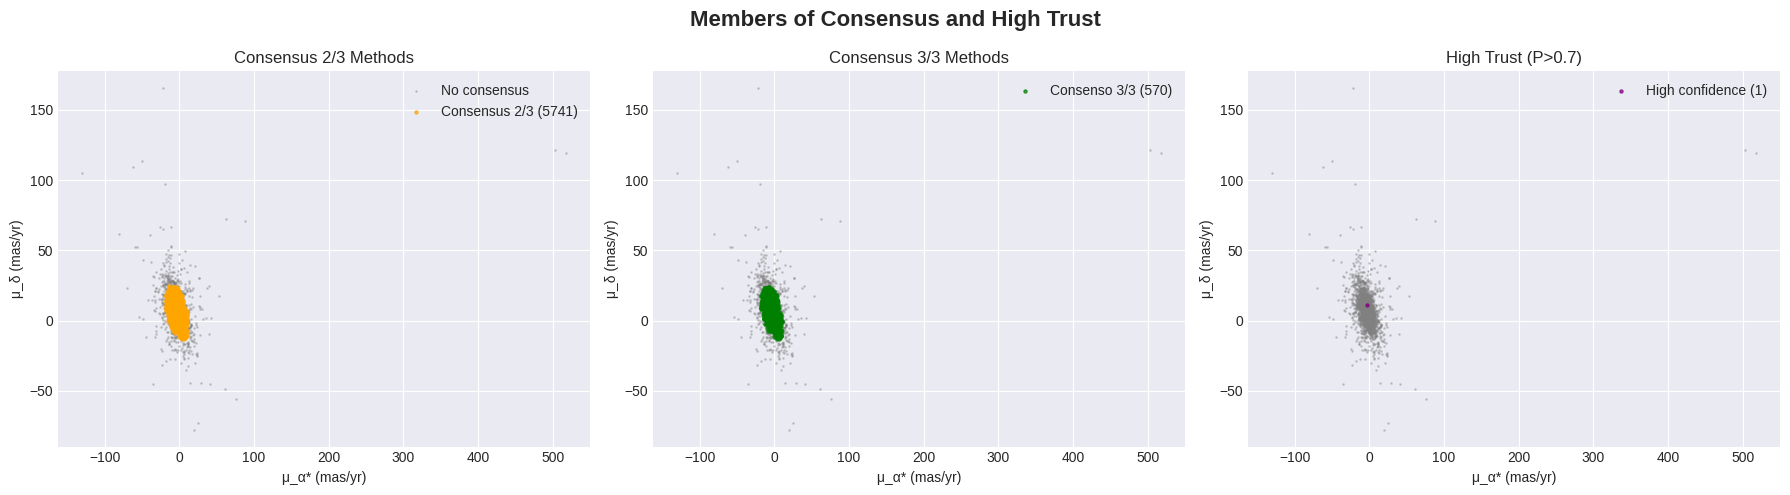


FINAL RECOMMENDATIONS:

1. For preliminary analyses: Use HDBSCAN. It is robust, handles variable densities,
   and provides useful probabilities.

2. For maximum confidence: Use 3/3 consensus or high probabilistic confidence.
   These are the most reliable stars.

3. For detailed studies: Combine GMM (for formal statistical modelling) with
   HDBSCAN (for robustness in variable densities).

4. For complex clusters with sub-structures: HDBSCAN is superior because it detects
   hierarchies naturally.

5. DBSCAN is useful as a quick first approximation, but HDBSCAN is almost always
   preferable.

6. Always visually verify the results. Algorithms are not infallible
   and require parameter adjustment depending on the specific cluster.


ANALYSIS COMPLETED


In [18]:
# =============================================================================
# BLOCK 6: RECOMMENDATIONS AND CONSENSUS
# =============================================================================

print("\n" + "="*70)
print("BLOCK 6: CONSENSUS MEMBERS AND RECOMMENDATIONS")
print("="*70)

print("""
A robust strategy is to create a list of ‘consensus members’: stars
that at least two (or preferably three) methods identify as members.
This reduces false positives and increases confidence in the classification.

We can also use GMM and HDBSCAN to set probability thresholds,
assigning greater confidence to stars with a high probability of membership.
""")

# Create different levels of consensus
consensus_2 = (mask_members_dbscan.astype(int) + 
               mask_members_hdbscan.astype(int) + 
               mask_members_gmm.astype(int)) >= 2

consensus_3 = mask_members_dbscan & mask_members_hdbscan & mask_members_gmm

# Highly trusted members using probabilities
high_confidence_hdbscan = (labels_hdbscan == main_cluster_id_hdb) & (probabilities_hdbscan > 0.7)
high_confidence_gmm = prob_cluster_gmm > 0.7
high_confidence = high_confidence_hdbscan & high_confidence_gmm

print(f"\nMembers by level of consensus:")
print(f"  Consensus 2/3 methods: {np.sum(consensus_2)} estrellas")
print(f"  Consensus 3/3 methods: {np.sum(consensus_3)} estrellas")
print(f"  High confidence (P>0.7 in HDBSCAN and GMM): {np.sum(high_confidence)} stars")

# Final visualisation
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Members of Consensus and High Trust', fontsize=16, fontweight='bold')

# Consenso 2/3
axes[0].scatter(pmra[~consensus_2], pmdec[~consensus_2], s=1, alpha=0.3, 
                color='gray', label='No consensus')
axes[0].scatter(pmra[consensus_2], pmdec[consensus_2], s=5, alpha=0.7, 
                color='orange', label=f'Consensus 2/3 ({np.sum(consensus_2)})')
axes[0].set_xlabel('μ_α* (mas/yr)')
axes[0].set_ylabel('μ_δ (mas/yr)')
axes[0].set_title('Consensus 2/3 Methods')
axes[0].legend()

# Consenso 3/3
axes[1].scatter(pmra[~consensus_3], pmdec[~consensus_3], s=1, alpha=0.3, 
                color='gray')
axes[1].scatter(pmra[consensus_3], pmdec[consensus_3], s=5, alpha=0.7, 
                color='green', label=f'Consenso 3/3 ({np.sum(consensus_3)})')
axes[1].set_xlabel('μ_α* (mas/yr)')
axes[1].set_ylabel('μ_δ (mas/yr)')
axes[1].set_title('Consensus 3/3 Methods')
axes[1].legend()

# Alta confianza
axes[2].scatter(pmra[~high_confidence], pmdec[~high_confidence], s=1, alpha=0.3, 
                color='gray')
axes[2].scatter(pmra[high_confidence], pmdec[high_confidence], s=5, alpha=0.7, 
                color='purple', label=f'High confidence ({np.sum(high_confidence)})')
axes[2].set_xlabel('μ_α* (mas/yr)')
axes[2].set_ylabel('μ_δ (mas/yr)')
axes[2].set_title('High Trust (P>0.7)')
axes[2].legend()

plt.tight_layout()
plt.savefig('final_consensus.png', dpi=150, bbox_inches='tight')
plt.show()

print("""
FINAL RECOMMENDATIONS:

1. For preliminary analyses: Use HDBSCAN. It is robust, handles variable densities,
   and provides useful probabilities.

2. For maximum confidence: Use 3/3 consensus or high probabilistic confidence.
   These are the most reliable stars.

3. For detailed studies: Combine GMM (for formal statistical modelling) with
   HDBSCAN (for robustness in variable densities).

4. For complex clusters with sub-structures: HDBSCAN is superior because it detects
   hierarchies naturally.

5. DBSCAN is useful as a quick first approximation, but HDBSCAN is almost always
   preferable.

6. Always visually verify the results. Algorithms are not infallible
   and require parameter adjustment depending on the specific cluster.
""")

print("\n" + "="*70)
print("ANALYSIS COMPLETED")
print("="*70)
